## Importing Libraries

In [ ]:
import os
import cv2
import math
import mahotas
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

In [181]:
import warnings
warnings.filterwarnings('ignore')

## Processing data

In [59]:
benign_list=listdir("benign")
malignant_list=listdir("malignant")

Resizing all images to 100x100

In [60]:
img=cv2.imread("malignant/"+malignant_list[0])
img=cv2.resize(img,(100,100))
l=list(img[:,:,0].flatten())
len(l)

10000

In [61]:
def create_pixel_features(image_list,size=100) :
    '''
    Extracting pixel features from a given image list
    :param image_list: list, BGR image
    :return feature_df: Pandas DataFrame, contains pixel features of the image
    '''
    m=len(image_list)
    n=(size**2)*3
    features=np.zeros((m,n))
    feature_df=pd.DataFrame()
    target=[]
    for i,(image,label) in enumerate(image_list) :
        if label==1 :
                image=cv2.imread("malignant/"+image)
        else :
            image=cv2.imread("benign/"+image)
        image=cv2.resize(image,(size,size))
        feature=list(image[:,:,0].flatten())+list(image[:,:,1].flatten())+list(image[:,:,2].flatten())
        features[i,:]=feature
        target.append(label)
    for i in range(size**2) :
        feature_df["pixel_"+str(i+1) + "_blue"]=features[:,i]
    for i in range(size**2,2*size**2) :
        feature_df["pixel_"+str(i+1-size**2) + "_green"]=features[:,i]
    for i in range(2*size**2,3*size**2) :
        feature_df["pixel_"+str(i+1-2*size**2) + "_red"]=features[:,i]
    feature_df["label"]=target
    return feature_df

In [142]:
def create_pca_features(train_x,test_x,var_exp=0.95) :
    '''
    Extracting PCA features for input train and test dataframe
    :param train_x: Pandas Dataframe, X train
    :param test_y: Pandas Dataframe, X test
    :return train_pca, test_pca: Pandas DataFrame, contains pca features
    '''
    standard_scaler=StandardScaler()
    scaled_feature_df=standard_scaler.fit_transform(train_x)
    scaled_feature_df_test=standard_scaler.transform(test_x)
    pca_features=pd.DataFrame()
    pca = PCA(n_components=var_exp) 
    train_pca=pca.fit_transform(scaled_feature_df)
    test_pca=pca.transform(scaled_feature_df_test)
    return train_pca,test_pca

Getting all images ( benign and malignant in a list)

In [63]:
image_list=[(i,0) for i in benign_list]
image_list=image_list+[(i,1) for i in malignant_list]
len(image_list)

300

## Pixel Models

### Getting PCA features for all images

In [64]:
pixel_feature_df=create_pixel_features(image_list)
pixel_feature_df.shape

(300, 30001)

In [65]:
target=pixel_feature_df.pop("label")

In [141]:
train_x,test_x,train_y,test_y=train_test_split(pixel_feature_df,
                            target,stratify=target,test_size=0.2)

In [143]:
train_pca,test_pca=create_pca_features(train_x,test_x)

In [144]:
train_pca.shape

(240, 61)

### RandomForest Model

In [145]:
random_forest=RandomForestClassifier(n_estimators=300)
parameters={'max_depth':[i for i in range(6,18)]}
random_forest=GridSearchCV(random_forest,parameters,scoring='roc_auc',cv=5)
random_forest.fit(train_pca,train_y)
print(random_forest.best_score_)
print(random_forest.best_params_)

0.7902777777777776
{'max_depth': 6}


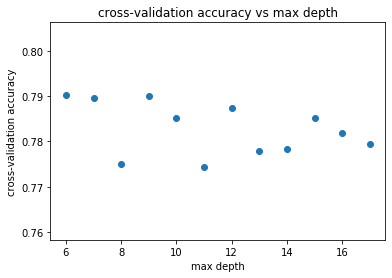

In [146]:
plt.scatter([i for i in range(6,18)],random_forest.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs max depth")
plt.xlabel("max depth")
plt.ylabel("cross-validation accuracy")
plt.savefig("md-rf")

### XGBoost Model

In [148]:
xgb1=XGBClassifier(n_estimators=750)
parameters={'learning_rate':[0.2,0.4,0.6,0.8,1]}
xgb1=GridSearchCV(xgb1,parameters,scoring='roc_auc',cv=5)
xgb1.fit(train_pca,train_y)
print(xgb1.best_score_)
print(xgb1.best_params_)

0.7722222222222223
{'learning_rate': 0.2}


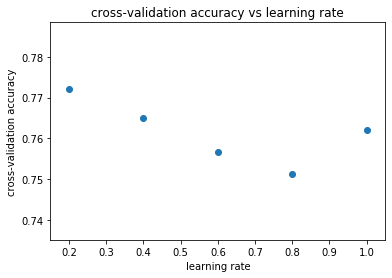

In [149]:
plt.scatter([0.2,0.4,0.6,0.8,1],xgb1.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs learning rate")
plt.xlabel("learning rate")
plt.ylabel("cross-validation accuracy")
plt.savefig("lr-xgb")

In [150]:
xgb2=XGBClassifier(n_estimators=750,learning_rate=0.2)
parameters={'max_depth':[i for i in range(2,7)]}
xgb2=GridSearchCV(xgb2,parameters,scoring='roc_auc',cv=5)
xgb2.fit(train_pca,train_y)
print(xgb2.best_score_)
print(xgb2.best_params_)

0.7770833333333335
{'max_depth': 6}


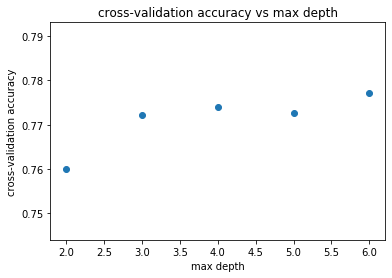

In [151]:
plt.scatter([i for i in range(2,7)],xgb2.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs max depth")
plt.xlabel("max depth")
plt.ylabel("cross-validation accuracy")
plt.savefig("md-xgb")

### Logistic Regression Model

In [178]:
lr1=LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.9)
parameters={'C' : [i for i in range(1,8)]}
lr1=GridSearchCV(lr1,parameters,scoring='roc_auc',cv=5)
lr1.fit(train_pca,train_y)
print(lr1.best_score_)
print(lr1.best_params_)

0.7354166666666667
{'C': 1}


In [1]:
def get_test_accuracy(pred,test_y) :
    '''Returns accuracy for input predictions
    :param pred: np array of predictions
    :param test_y: np.array of actual y values
    :return Accuracy score
    '''
    i=0
    for r in pred==test_y :
        if r :
            i+=1
    return i/len(list(pred))

Plotting the confusion matrix for RandomForest model

In [163]:
rf_predictions=random_forest.predict(test_pca)
rf_test_acc=get_test_accuracy(rf_predictions,test_y)
print("accuracy of random forest on test data is - ",rf_test_acc)
df_confusion = pd.crosstab(test_y, rf_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

accuracy of random forest on test data is -  0.6666666666666666


Predicted,0,1,All
Actual,,,
0,21,9,30
1,11,19,30
All,32,28,60


Plotting the confusion matrix for XGBoost model

In [217]:
xgb_predictions=xgb2.predict(test_pca)
xgb_test_acc=get_test_accuracy(xgb_predictions,test_y)
print("accuracy of gradient boosting on test data is - ",xgb_test_acc)
df_confusion = pd.crosstab(test_y, xgb_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

accuracy of gradient boosting on test data is -  0.6833333333333333


Predicted,0,1,All
Actual,,,
0,21,9,30
1,10,20,30
All,31,29,60


Plotting the confusion matrix for Logistic Regression model

In [179]:
lr_predictions=lr1.predict(test_pca)
lr_test_acc=get_test_accuracy(lr_predictions,test_y)
print("accuracy of logistic regression on test data is - ",lr_test_acc)
df_confusion = pd.crosstab(test_y, lr_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

accuracy of logistic regression on test data is -  0.6333333333333333


Predicted,0,1,All
Actual,,,
0,17,13,30
1,9,21,30
All,26,34,60


## Interpretable Feature Models

In [180]:
def extract_haralick(img):
    """Extract Haralick features of an image. Haralick features are texture descriptors.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains 13 Haralick features of the image
    """

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.haralick(gray).mean(axis=0)
    return feature

In [ ]:
def get_1st_square(img,center) :
    """Extract the first bounding box which contains at least a single pixel
    :param img: ndarray, BGR image
    :param center: int, location of the centre
    :return s: int, distance to move from the centre of the image to get to the boundy box edge
    """
    s=1
    while s<min(center[0],center[1]) :
        xs=[i for i in range(center[0]-s,center[0]+s+1)]
        ys=[i for i in range(center[1]-s,center[1]+s+1)]
        for x in xs :
            for y in ys :
                if x==center[0] and y==center[1] :
                    continue
                if img[x][y]==0 :
                    return s
        s+=1   
    return 0 

In [187]:
def get_bounding_square(img,center,limit) :
    """Get the bounding square based on the center and limit
    :param img: ndarray, BGR image
    :param center: int, location of the centre
    :param limit: int, edge of the image
    :return s: int, Bounding box
    """
    s=get_1st_square(img,center)
    count=0
    c_old=0
    while s<min(center[0],center[1]) :
        c_new=c_old
        points=[]
        for x in [center[0]-s,center[0]+s] :
            for y in range(center[1]-s,center[1]+s+1) :
                points.append((x,y))
        for y in [center[1]-s,center[1]+s] :
            for x in range(center[0]-s,center[0]+s+1) :
                points.append((x,y))
        points=set(points)
        for p in points :
            if img[p[0],p[1]]==0 :
                c_new+=1
        #print(c_new)
        if c_new > c_old :
            count=0
        else :
            count+=1
        if count==limit :
            return s
        c_old=c_new
        s+=1
    return s

def create_square(img,center,limit) :
    _,thresh=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    s=get_bounding_square(thresh,center,limit)
    return s,thresh[(center[0]-s):(center[0]+s),(center[1]-s):(center[1]+s)],img[(center[0]-s):(center[0]+s),(center[1]-s):(center[1]+s)]

In [204]:
def create_features(image_list):
    """Create interpretable features of an image.
    :param image_list: list, list of images
    :return feature_df: Pandas Dataframe, contains 22 relevant features for all images
    """
    feature_df=pd.DataFrame()
    area_feats=[]
    perimeter_feats=[]
    circularity_feats=[]
    irregularity_feats=[]
    aspect_ratio_feats=[]
    blue_feats=[]
    green_feats=[]
    red_feats=[]
    haralick_features = []
    color_hist_features = []
    hu_momemts_features = []
    labels=[]
    for image,label in image_list :
        if '.jpg' in image :
            if label==1 :
                image=cv2.imread("malignant/"+image)
            else :
                image=cv2.imread("benign/"+image)
        image=cv2.resize(image,(400,400))
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        gray = cv2.medianBlur(gray,5)
        center=(int(gray.shape[0]/2),int(gray.shape[1]/2))
        s,ti,oi=create_square(gray,center,2)
        contours, hierarchy = cv2.findContours(ti, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        c = sorted(contours, key = cv2.contourArea,reverse=True)[1]
        area=cv2.contourArea(c)
        area_feats.append(area)
        perimeter=cv2.arcLength(c,True)
        perimeter_feats.append(perimeter)
        circularity_index=4*area*math.pi/perimeter**2
        circularity_feats.append(circularity_index)
        irregularity_index1=perimeter/area
        irregularity_feats.append(irregularity_index1)
        x,y,w,h=cv2.boundingRect(c)
        aspect_ratio=float(w)/h
        aspect_ratio_feats.append(aspect_ratio)
        bgr=np.array(cv2.mean(image[y:y+h,x:x+w])).astype(np.uint8)
        blue=bgr[0]
        green=bgr[1]
        red=bgr[2]
        blue_feats.append(blue)
        green_feats.append(green)
        red_feats.append(red)
        labels.append(label)
        #Extract Haralick features which carry texture information
        haralick_feature = extract_haralick(image)
        haralick_features.append(haralick_feature)
    feature_df['area']=area_feats
    feature_df['perimeter']=perimeter_feats
    feature_df['circularity_index']=circularity_feats
    feature_df['irregularity_index1']=irregularity_feats
    feature_df['aspect_ratio']=aspect_ratio_feats
    feature_df['blue']=blue_feats
    feature_df['green']=green_feats
    feature_df['red']=red_feats
    #Creating Dataframe for Haralick features
    haralick_df = pd.DataFrame(haralick_features)
    return pd.concat([feature_df, haralick_df], axis=1)

### Creating features for all images

In [205]:
feature_df=create_features(image_list)

In [206]:
feature_df.head()

,area,perimeter,circularity_index,irregularity_index1,aspect_ratio,blue,green,red,0,1,...,3,4,5,6,7,8,9,10,11,12
0,12158.0,517.872145,0.569675,0.042595,0.797297,144,135,144,0.001607,10.789657,...,1190.849888,0.395058,277.724359,4752.609896,7.686900,10.151408,0.000994,2.739637,-0.483277,0.999162
1,2617.0,201.622364,0.808977,0.077043,0.763889,175,161,171,0.003973,7.745002,...,280.145210,0.393593,359.580373,1112.835837,6.339224,8.700100,0.000940,2.587047,-0.376350,0.990417
2,14205.5,473.830515,0.795097,0.033355,0.701220,199,186,239,0.003893,13.530919,...,812.151117,0.383619,400.369377,3235.073548,6.581364,9.109057,0.000742,2.771257,-0.377368,0.992108
3,52749.0,996.229572,0.667890,0.018886,0.846416,115,109,138,0.002035,25.494681,...,2764.571781,0.381212,280.154492,11032.792441,7.791259,10.426677,0.000817,3.091104,-0.467311,0.999081
4,90436.5,1608.770764,0.439102,0.017789,0.796992,92,117,210,0.000830,73.241764,...,1495.851807,0.324052,309.463294,5910.165462,8.079668,11.031336,0.000554,3.316208,-0.443894,0.998955


In [207]:
train_x1=feature_df.iloc[train_y.index]
test_x1=feature_df.iloc[test_y.index]

### RandomForest Model

In [210]:
random_forest1=RandomForestClassifier(n_estimators=300)
parameters={'max_depth':[i for i in range(6,18)]}
random_forest1=GridSearchCV(random_forest1,parameters,scoring='roc_auc',cv=5)
random_forest1.fit(train_x1,train_y)
print(random_forest1.best_score_)
print(random_forest1.best_params_)

0.7364583333333333
{'max_depth': 6}


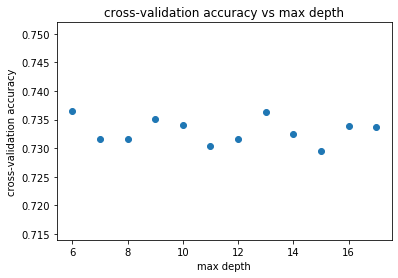

In [211]:
plt.scatter([i for i in range(6,18)],random_forest1.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs max depth")
plt.xlabel("max depth")
plt.ylabel("cross-validation accuracy")
plt.savefig("md-rf1")

#### RandomForest Confusion Matrix

In [212]:
rf_predictions1=random_forest1.predict(test_x1)
rf_test_acc=get_test_accuracy(rf_predictions1,test_y)
print("accuracy of random forest on test data is - ",rf_test_acc)
df_confusion = pd.crosstab(test_y, rf_predictions1, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

accuracy of random forest on test data is -  0.7


Predicted,0,1,All
Actual,,,
0,21,9,30
1,9,21,30
All,30,30,60


### XGBoost Model

In [213]:
xgb3=XGBClassifier(n_estimators=750)
parameters={'learning_rate':[0.2,0.4,0.6,0.8,1]}
xgb3=GridSearchCV(xgb3,parameters,scoring='roc_auc',cv=5)
xgb3.fit(train_x1,train_y)
print(xgb3.best_score_)
print(xgb3.best_params_)

0.6753472222222221
{'learning_rate': 0.4}


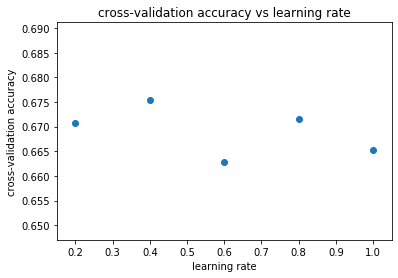

In [214]:
plt.scatter([0.2,0.4,0.6,0.8,1],xgb3.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs learning rate")
plt.xlabel("learning rate")
plt.ylabel("cross-validation accuracy")
plt.savefig("lr-xgb3")

In [215]:
xgb4=XGBClassifier(n_estimators=750,learning_rate=0.4)
parameters={'max_depth':[i for i in range(2,7)]}
xgb4=GridSearchCV(xgb4,parameters,scoring='roc_auc',cv=5)
xgb4.fit(train_x1,train_y)
print(xgb4.best_score_)
print(xgb4.best_params_)

0.6895833333333333
{'max_depth': 5}


#### XGBoost Confusion Matrix

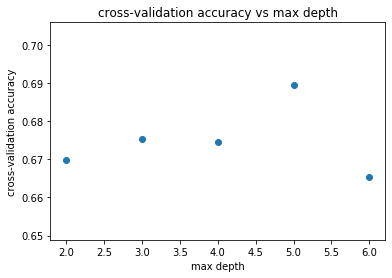

In [216]:
plt.scatter([i for i in range(2,7)],xgb4.cv_results_['mean_test_score'])
plt.title("cross-validation accuracy vs max depth")
plt.xlabel("max depth")
plt.ylabel("cross-validation accuracy")
plt.savefig("md-xgb4")

In [218]:
xgb_predictions1=xgb4.predict(test_x1)
xgb_test_acc=get_test_accuracy(xgb_predictions1,test_y)
print("accuracy of gradient boosting on test data is - ",xgb_test_acc)
df_confusion = pd.crosstab(test_y, xgb_predictions1, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

accuracy of gradient boosting on test data is -  0.65


Predicted,0,1,All
Actual,,,
0,19,11,30
1,10,20,30
All,29,31,60
